### tiff2nc
Converts geoTiff files from soilGrids to stacked .nc files for use in mksurf

Data available at https://files.isric.org/soilgrids/latest/data_aggregated/5000m/

Metadata (including the DOI for citations) can be found here: https://data.isric.org/

retrieved with the following command:

`wget -r --no-parent -A 'bdod_*.tif' https://files.isric.org/soilgrids/latest/data_aggregated/5000m/bdod/' `

Finally, information about units & conversions for each variable are here: https://www.isric.org/explore/soilgrids/faq-soilgrids#What_do_the_filename_codes_mean


In [1]:
import xarray as xr
import rioxarray
from affine import Affine
from glob import glob
import dask
from distributed import wait
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

%matplotlib inline

### Get some workers

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='1GB')
cluster.scale(20)
cluster

/glade/u/home/wwieder/miniconda3/envs/tiff2nc/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:35851,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Quick look at a single soil property
#### open as rioxarray to bring in meta and projection data

In [11]:
path ='/glade/scratch/wwieder/SoilGrids/soilgrids/latest/data_aggregated/5000m/'
depth = ['0-5','5-15','15-30','30-60','60-100','100-200']
layer_top =    [0.,5. ,15.,30.,60. ,100.]
layer_bottom = [5.,15.,30.,60.,100.,200.]
var = 'clay'
infile = [path + var + '/' + var +"_"+ depth[d] + 'cm_mean_5000.tif' 
          for d in range(len(depth))]
rds = xr.concat([rioxarray.open_rasterio(infile[f]) for f in range(len(infile))],'layer_bottom')
rds = rds.squeeze().assign_coords(layer_bottom=layer_bottom)
rds.name = var
rds

['/glade/scratch/wwieder/SoilGrids/soilgrids/latest/data_aggregated/5000m/clay/clay_0-5cm_mean_5000.tif',
 '/glade/scratch/wwieder/SoilGrids/soilgrids/latest/data_aggregated/5000m/clay/clay_5-15cm_mean_5000.tif',
 '/glade/scratch/wwieder/SoilGrids/soilgrids/latest/data_aggregated/5000m/clay/clay_15-30cm_mean_5000.tif',
 '/glade/scratch/wwieder/SoilGrids/soilgrids/latest/data_aggregated/5000m/clay/clay_30-60cm_mean_5000.tif',
 '/glade/scratch/wwieder/SoilGrids/soilgrids/latest/data_aggregated/5000m/clay/clay_60-100cm_mean_5000.tif',
 '/glade/scratch/wwieder/SoilGrids/soilgrids/latest/data_aggregated/5000m/clay/clay_100-200cm_mean_5000.tif']

### Loop over properties & write .nc files

In [25]:
path ='/glade/scratch/wwieder/SoilGrids/soilgrids/latest/data_aggregated/5000m/'
depth = ['0-5','5-15','15-30','30-60','60-100','100-200']
layer_top =    [0.,5. ,15.,30.,60. ,100.]
layer_bottom = [5.,15.,30.,60.,100.,200.]

Var = ['bdod','cec','cfvo','clay','nitrogen','ocd','phh2o','sand','soc']

for v in range(len(Var)):
    var = Var[v]
    infile = [path + var + '/' + var +"_"+ depth[d] + 'cm_mean_5000.tif' 
          for d in range(len(depth))]


    ## Define attributes for each property
    if var == 'bdod':
        long_name, conversion, units = 'Bulk density of the fine earth fraction', 100, 'kg/dm³'
    if var == 'cec':
        long_name, conversion, units = 'Cation Exchange Capacity', 10, 'cmol(c)/kg'
    if var == 'cfvo':
        long_name, conversion, units = 'Volumetric fraction of coarse fragments (> 2 mm)', 10, 'cm3/100cm3 (vol%)'  
    if var == 'clay':
        long_name, conversion, units = 'Proportion of clay particles (< 0.002 mm) in the fine earth fraction', 10, 'g/100g (%)'  
    if var == 'nitrogen':
        long_name, conversion, units = 'Total nitrogen (N)', 100, 'g/kg'
    if var == 'ocd':
        long_name, conversion, units = 'Organic carbon density', 10, 'kg/m³'
    if var == 'phh2o':
        long_name, conversion, units = 'Soil pH', 10, 'pH'    
    if var == 'sand':
        long_name, conversion, units = 'Proportion of sand particles (> 0.05 mm) in the fine earth fraction', 10, 'g/100g (%)'
    if var == 'silt':
        long_name, conversion, units = 'Proportion of silt particles (≥ 0.002 mm and ≤ 0.05 mm) in the fine earth fraction	', 10, 'g/100g (%)'
    if var == 'soc':
        long_name, conversion, units = 'Soil organic carbon content in the fine earth fraction', 10, 'g/kg'

    ## Open as rioxarray to bring in meta and projection data
    rds = xr.concat([rioxarray.open_rasterio(infile[f]) for f in range(len(infile))],'layer_bottom')
    rds = rds.squeeze().assign_coords(layer_bottom=layer_bottom)
    rds.name = var
    FillValue = rds.attrs['_FillValue']
    scale_factor = rds.attrs['scale_factor']
    rds = rds/conversion
    rds.attrs['_FillValue'] = FillValue/conversion
    print(var + ' scale factor '+str(scale_factor))

    ## Shift projection, clean up dimensions
    rds_lonlat = rds.rio.reproject("EPSG:4326")
    rds_lonlat = rds_lonlat.rename({'x':'lon','y':'lat'})
    rds_lonlat = rds_lonlat.drop(['spatial_ref','band'])
    rds_lonlat.layer_bottom.attrs['axis'] = 'Z'
    rds_lonlat.layer_bottom.attrs['units'] = 'cm'
    rds_lonlat.layer_bottom.attrs['long_name'] = 'depth to bottom of soil layer'
    rds_lonlat.attrs['long_name'] = long_name 
    rds_lonlat.attrs['units'] = units 


    ## Write out .nc file
    fout = '/glade/scratch/wwieder/SoilGrids/ncMerged/' + var +"_0-300_mean_5000.nc"
    rds_lonlat.to_netcdf(fout)
    print('wrote '+fout)

    #rds_lonlat.where(rds_lonlat !=rds_lonlat.attrs['_FillValue']).isel(layer_bottom=0).plot();
    #rds_lonlat

bdod scale factor 1.0
wrote /glade/scratch/wwieder/SoilGrids/ncMerged/bdod_0-300_mean_5000.nc
cec scale factor 1.0
wrote /glade/scratch/wwieder/SoilGrids/ncMerged/cec_0-300_mean_5000.nc
cfvo scale factor 1.0
wrote /glade/scratch/wwieder/SoilGrids/ncMerged/cfvo_0-300_mean_5000.nc
clay scale factor 1.0
wrote /glade/scratch/wwieder/SoilGrids/ncMerged/clay_0-300_mean_5000.nc
nitrogen scale factor 1.0
wrote /glade/scratch/wwieder/SoilGrids/ncMerged/nitrogen_0-300_mean_5000.nc
ocd scale factor 1.0
wrote /glade/scratch/wwieder/SoilGrids/ncMerged/ocd_0-300_mean_5000.nc


In [ ]:
## quick text to see if .nc files read back in correctly.

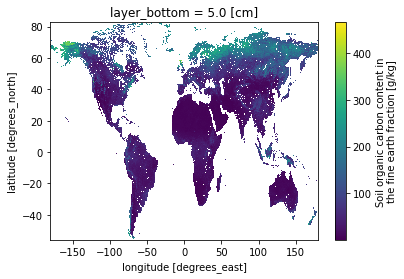

In [24]:
fout
ds = xr.open_dataset(fout)
ds.soc.isel(layer_bottom=0).plot() ;

---------------

In [26]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python

ModuleNotFoundError: No module named 'watermark'